In [5]:
import pandas as pd
import numpy as np
import os
import re    # for regular expressions
import nltk  # for text manipulation
import string
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
dftrain = pd.read_csv('Tweets_emtions.csv')

In [7]:
dftrain.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [8]:
print(dftrain.isnull().values.any())

True


In [9]:
dftest = pd.read_csv('Tweets_emtions.csv')

In [10]:
print(dftest.isnull().sum())

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64


In [11]:
dftrain['selected_text'].value_counts()

good                                                                                                                               199
love                                                                                                                               185
Happy                                                                                                                              163
miss                                                                                                                               143
happy                                                                                                                              106
                                                                                                                                  ... 
Trying to figure out what to do tonight. See the game? Social events w. friends? Or stay home and play the s**t out of my drums      1
I`m on a budget...boo!                                 

In [12]:
cnt1 = len(dftrain[dftrain['selected_text']==1])
cnt0 = len(dftrain[dftrain['selected_text']==0])

if cnt1 + cnt0 != 0:
    pct0 = cnt0 / (cnt1 + cnt0)
    print('percent 0:', round(pct0 * 100, 2))
    pct1 = cnt1 / (cnt0 + cnt1)
    print('percent 1:', round(pct1 * 100, 2))
else:
    print('Both categories have zero count. Unable to calculate percentages.')


Both categories have zero count. Unable to calculate percentages.


In [13]:
dftrain.shape

(27481, 4)

In [14]:
dftest.shape

(27481, 4)

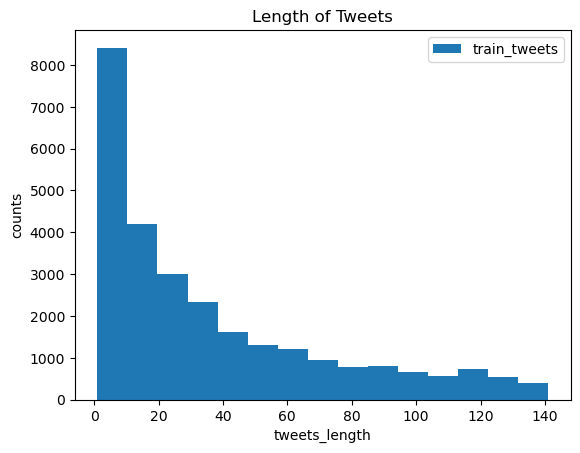

In [15]:
trainlen = dftrain['selected_text'].str.len()
plt.hist(trainlen,label ='train_tweets',bins=15)
plt.title('Length of Tweets')
plt.xlabel('tweets_length')
plt.ylabel('counts')
plt.legend()
plt.show()


In [16]:
import numpy as np

def word_count(sentence):
    if isinstance(sentence, str):
        return len(sentence.split())
    else:
        return np.nan    
dftrain['word count'] = dftrain['selected_text'].apply(word_count)
dftrain.head(3)


,textID,text,selected_text,sentiment,word count
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,7.0
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,2.0
2,088c60f138,my boss is bullying me...,bullying me,negative,2.0


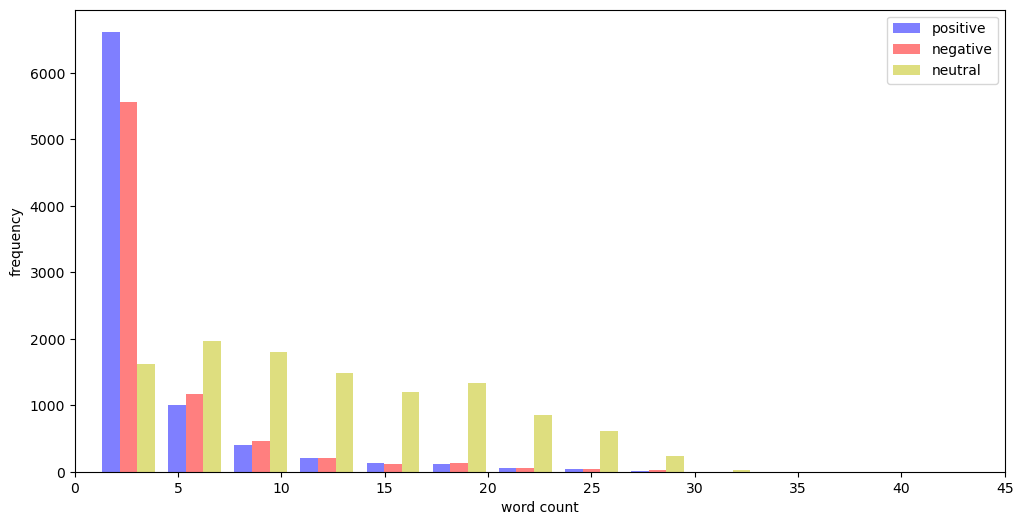

In [17]:
x = dftrain['word count'][dftrain.sentiment=='positive']
y = dftrain['word count'][dftrain.sentiment=='negative']
z = dftrain['word count'][dftrain.sentiment=='neutral']
plt.figure(figsize=(12,6))
plt.xlim(0,45)
plt.xlabel('word count')
plt.ylabel('frequency')
g = plt.hist([x,y,z], color=['b','r','y'], alpha=0.5, label=['positive','negative','neutral'])
plt.legend(loc='upper right')

In [18]:
import nltk
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV
import joblib
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer 
from collections import Counter


In [19]:
all_words = []
for line in list(dftrain['selected_text']):
    if isinstance(line, str):  # Check if the line is a string
        words = line.split()
        for word in words:
            all_words.append(word.lower())

# Print the list of all words
print(all_words)

['i`d', 'have', 'responded,', 'if', 'i', 'were', 'going', 'sooo', 'sad', 'bullying', 'me', 'leave', 'me', 'alone', 'sons', 'of', '****,', 'http://www.dothebouncy.com/smf', '-', 'some', 'shameless', 'plugging', 'for', 'the', 'best', 'rangers', 'forum', 'on', 'earth', 'fun', 'soooo', 'high', 'both', 'of', 'you', 'wow...', 'u', 'just', 'became', 'cooler.', 'as', 'much', 'as', 'i', 'love', 'to', 'be', 'hopeful,', 'i', 'reckon', 'the', 'chances', 'are', 'minimal', '=p', 'i`m', 'never', 'gonna', 'get', 'my', 'cake', 'and', 'stuff', 'like', 'dangerously', 'lost', 'test', 'test', 'from', 'the', 'lg', 'env2', 'uh', 'oh,', 'i', 'am', 'sunburned', '*sigh*', 'sick', 'onna', 'hes', 'just', 'not', 'that', 'into', 'you', 'oh', 'marly,', 'i`m', 'so', 'sorry!!', 'i', 'hope', 'you', 'find', 'her', 'soon!!', '<3', '<3', 'interesting.', 'is', 'cleaning', 'the', 'house', 'for', 'her', 'family', 'who', 'is', 'comming', 'later', 'today..', 'gotta', 'restart', 'my', 'computer', '..', 'i', 'thought', 'win7', '

In [20]:
data = dftrain.append(dftest,ignore_index=True)

C:\Users\geetk\AppData\Local\Temp\ipykernel_12652\593515134.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = dftrain.append(dftest,ignore_index=True)


In [21]:
data.head()

,textID,text,selected_text,sentiment,word count
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,7.0
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,2.0
2,088c60f138,my boss is bullying me...,bullying me,negative,2.0
3,9642c003ef,what interview! leave me alone,leave me alone,negative,3.0
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,3.0


In [22]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt


In [23]:
import re

def remove_pattern(input_txt, pattern):
    if isinstance(input_txt, str):
        r = re.findall(pattern, input_txt)
        for i in r:
            input_txt = re.sub(i, '', input_txt)
    return input_txt

data['tidy_tweet'] = data['selected_text'].apply(lambda x: remove_pattern(str(x), "@[\w]*"))


In [24]:
data['selected_text'] = data['selected_text'].str.replace("[^a-zA-Z#]", " ") 
data.head(10)


C:\Users\geetk\AppData\Local\Temp\ipykernel_12652\3174292489.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  data['selected_text'] = data['selected_text'].str.replace("[^a-zA-Z#]", " ")


,textID,text,selected_text,sentiment,word count,tidy_tweet
0,cb774db0d1,"I`d have responded, if I were going",I d have responded if I were going,neutral,7.0,"I`d have responded, if I were going"
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,2.0,Sooo SAD
2,088c60f138,my boss is bullying me...,bullying me,negative,2.0,bullying me
3,9642c003ef,what interview! leave me alone,leave me alone,negative,3.0,leave me alone
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...",Sons of,negative,3.0,"Sons of ****,"
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,http www dothebouncy com smf some shameles...,neutral,12.0,http://www.dothebouncy.com/smf - some shameles...
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive,1.0,fun
7,50e14c0bb8,Soooo high,Soooo high,neutral,2.0,Soooo high
8,e050245fbd,Both of you,Both of you,neutral,3.0,Both of you
9,fc2cbefa9d,Journey!? Wow... u just became cooler. hehe....,Wow u just became cooler,positive,5.0,Wow... u just became cooler.


In [25]:
data['selected_text'] = data['selected_text'].apply(lambda x: ' '.join([w for w in str(x).split() if len(w) > 3]))


In [26]:
tokenized_tweet = data['selected_text'].apply(lambda x: x.split()) # tokenizing 
tokenized_tweet.head()


0    [have, responded, were, going]
1                            [Sooo]
2                        [bullying]
3                    [leave, alone]
4                            [Sons]
Name: selected_text, dtype: object

In [27]:
from nltk.stem.porter import * 
stemmer = PorterStemmer() 
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])


In [28]:
data['selected_text']=tokenized_tweet

In [29]:
data['selected_text'].head()

0    [have, respond, were, go]
1                       [sooo]
2                      [bulli]
3                 [leav, alon]
4                        [son]
Name: selected_text, dtype: object

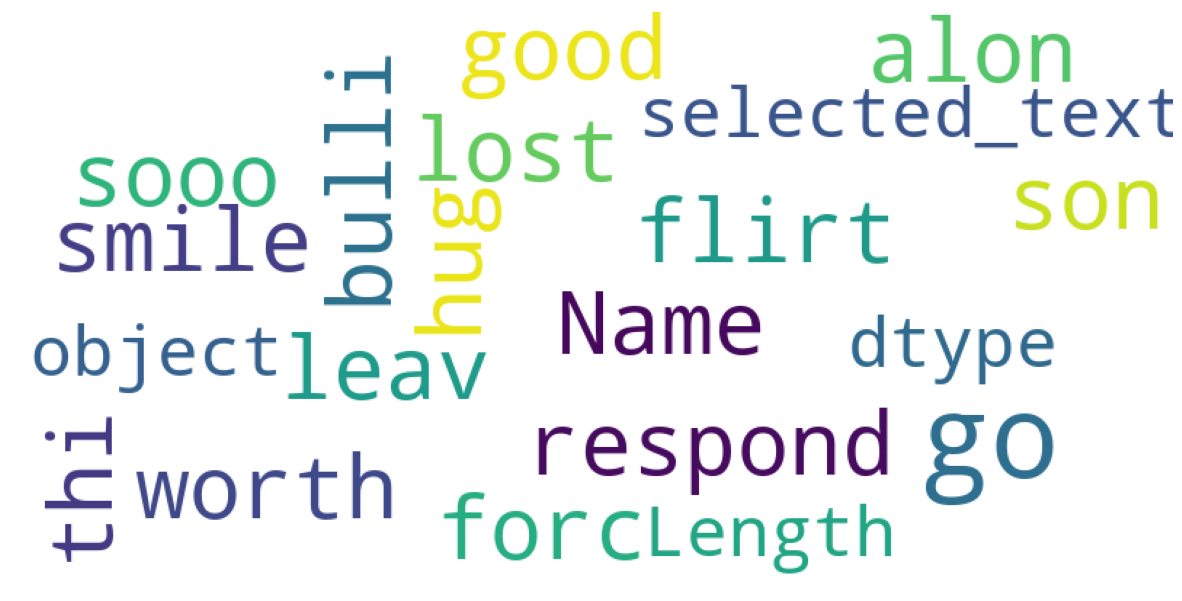

In [30]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
def wordcloud(data, title = None):
    wordcloud = WordCloud(
    background_color='white',
    stopwords=stopwords,
    max_words=250,
    max_font_size=40,
    scale=2,
    random_state=5 #chosen a andom by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud)
    plt.show()

wordcloud(data['selected_text'])



In [31]:
pip install wordcloud


Note: you may need to restart the kernel to use updated packages.


In [41]:
#normal_words =' '.join([str(text) for text in data['selected_text'][data['selected_text'] == 0]])

In [42]:
# from wordcloud import WordCloud, STOPWORDS
# import matplotlib.pyplot as plt

# def wordcloud(data, title=None):
#     positive_words = data[data['sentiment'] == 'positive']['selected_text'].values
#     negative_words = data[data['sentiment'] == 'negative']['selected_text'].values

#     positive_text = ' '.join(positive_words)
#     negative_text = ' '.join(negative_words)

#     stopwords = set(STOPWORDS)
#     stopwords.add('said')  # Example of adding custom stopwords if needed

#     # Create WordCloud objects for positive and negative sentiments
#     positive_wordcloud = WordCloud(background_color='white', stopwords=stopwords, max_words=250,
#                                    max_font_size=40, scale=2, random_state=5).generate(positive_text)

#     negative_wordcloud = WordCloud(background_color='white', stopwords=stopwords, max_words=250,
#                                    max_font_size=40, scale=2, random_state=5).generate(negative_text)

#     # Set color map for positive and negative sentiments
#     positive_cmap = plt.cm.Blues
#     negative_cmap = plt.cm.Reds

#     # Generate subplots and display word clouds
#     fig, axs = plt.subplots(1, 2, figsize=(15, 15))
#     axs[0].imshow(positive_wordcloud.recolor(color_func=positive_cmap), interpolation="bilinear")
#     axs[0].set_title("Positive Sentiment", fontsize=20)
#     axs[0].axis('off')

#     axs[1].imshow(negative_wordcloud.recolor(color_func=negative_cmap), interpolation="bilinear")
#     axs[1].set_title("Negative Sentiment", fontsize=20)
#     axs[1].axis('off')

#     if title:
#         fig.suptitle(title, fontsize=20, y=1.1)
    
#     plt.show()


In [43]:
# from wordcloud import WordCloud, STOPWORDS
# import matplotlib.pyplot as plt

# def wordcloud(data, title=None):
#     positive_words = data[data['sentiment'] == 'positive']['selected_text'].tolist()
#     negative_words = data[data['sentiment'] == 'negative']['selected_text'].tolist()

#     positive_text = ' '.join(map(str, positive_words))
#     negative_text = ' '.join(map(str, negative_words))

#     stopwords = set(STOPWORDS)
#     stopwords.add('said')  # Example of adding custom stopwords if needed

#     # Create WordCloud objects for positive and negative sentiments
#     positive_wordcloud = WordCloud(background_color='white', stopwords=stopwords, max_words=250,
#                                    max_font_size=40, scale=2, random_state=5).generate(positive_text)

#     negative_wordcloud = WordCloud(background_color='white', stopwords=stopwords, max_words=250,
#                                    max_font_size=40, scale=2, random_state=5).generate(negative_text)

#     # Set color map for positive and negative sentiments
#     positive_cmap = plt.cm.Blues
#     negative_cmap = plt.cm.Reds

#     # Generate subplots and display word clouds
#     fig, axs = plt.subplots(1, 2, figsize=(15, 15))
#     axs[0].imshow(positive_wordcloud.recolor(color_func=positive_cmap), interpolation="bilinear")
#     axs[0].set_title("Positive Sentiment", fontsize=20)
#     axs[0].axis('off')

#     axs[1].imshow(negative_wordcloud.recolor(color_func=negative_cmap), interpolation="bilinear")
#     axs[1].set_title("Negative Sentiment", fontsize=20)
#     axs[1].axis('off')

#     if title:
#         fig.suptitle(title, fontsize=20, y=1.1)

#     plt.show()


In [51]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

def wordcloud(data, title=None):
    positive_words = data[data['sentiment'] == 'positive']['selected_text'].tolist()
    negative_words = data[data['sentiment'] == 'negative']['selected_text'].tolist()
    neutral_words = data[data['sentiment'] == 'neutral']['selected_text'].tolist()

    positive_text = ' '.join(map(str, positive_words))
    negative_text = ' '.join(map(str, negative_words))
    neutral_text = ' '.join(map(str, neutral_words))

    stopwords = set(STOPWORDS)
    stopwords.add('said')  # Example of adding custom stopwords if needed

    # Create WordCloud objects for positive and negative sentiments
    positive_wordcloud = WordCloud(background_color='white', stopwords=stopwords, max_words=250,
                                   max_font_size=40, scale=2, random_state=5)
    positive_wordcloud.generate(positive_text)

    negative_wordcloud = WordCloud(background_color='white', stopwords=stopwords, max_words=250,
                                   max_font_size=40, scale=2, random_state=5)
    negative_wordcloud.generate(negative_text)
    
    neutral_wordcloud = WordCloud(background_color='white', stopwords=stopwords, max_words=250,
                                   max_font_size=40, scale=2, random_state=5)
    neutral_wordcloud.generate(neutral_text)

    # Set color map for positive and negative sentiments
    positive_color = 'blue'
    negative_color = 'red'
    neutral_color = 'yellow'
    # Generate subplots and display word clouds
    fig, axs = plt.subplots(1, 3, figsize=(15, 15))
    axs[0].imshow(positive_wordcloud, interpolation="bilinear")
    axs[0].set_title("Positive Sentiment", fontsize=20)
    axs[0].axis('off')
    axs[0].set_facecolor(positive_color)

    axs[1].imshow(negative_wordcloud, interpolation="bilinear")
    axs[1].set_title("Negative Sentiment", fontsize=20)
    axs[1].axis('off')
    axs[1].set_facecolor(negative_color)
    
    axs[2].imshow(neutral_wordcloud, interpolation="bilinear")
    axs[2].set_title("neutral Sentiment", fontsize=20)
    axs[2].axis('off')
    axs[2].set_facecolor(neutral_color)


    if title:
        fig.suptitle(title, fontsize=20, y=1.1)

    plt.show()


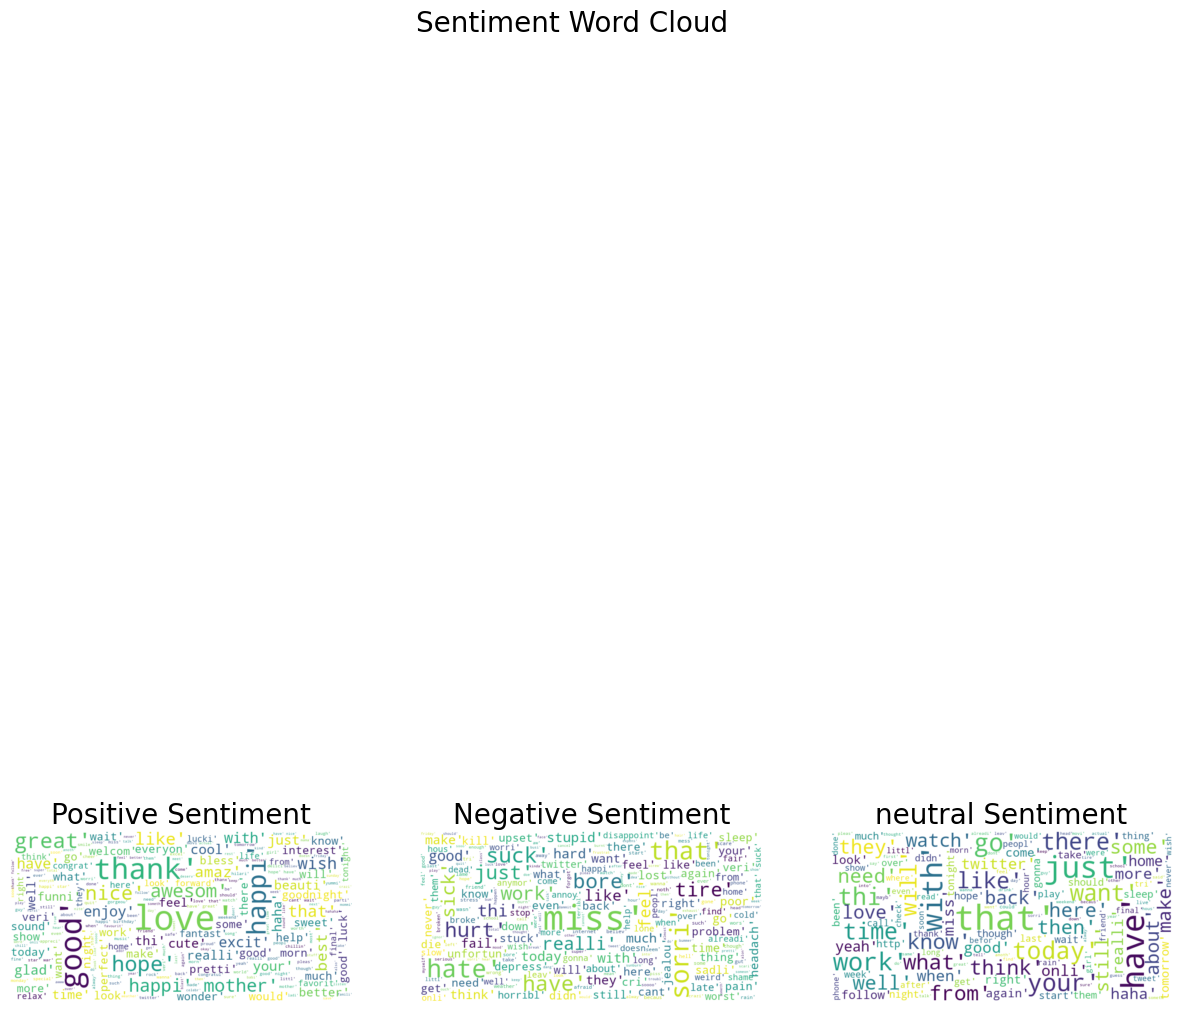

In [52]:
wordcloud(data, title='Sentiment Word Cloud')
